In [1]:
import pandas as pd 
import numpy as np
from scipy.optimize import minimize 
from functools import partial 
import matplotlib.pyplot as plt


# ------------------------------------ parameter ------------------------------------ 
# (0, 1) means long-only, since weighting of each stock are bounded to be in [0, 1].
# If you allow short selling, set lb=None, ub=None. Although the Efficient frontier would be smooth, the efficient portfolios maynot be tradable
lb = 0.0 #0.0 lower bound of the wrighting of each stock
ub = 1.0 #1.0  upper bound of the wrighting of each stock

# use weekly or monthly return for mean-variance analysis
useWeekly = False

## objective function = variance of portfolio, goal is to find the minimum variance portfolio for each specified target mean
def Var(w, cov_mat):
    return np.dot(w, np.dot(cov_mat,w.T))

In [2]:
#read_data
data = pd.read_excel('data/biggestETFData.xlsx',index_col = 0)
data.index = pd.to_datetime(data.index)

if useWeekly:
    data = data.resample('W').last()
else:
    data = data.resample('M').last()

data_ret = data.pct_change().dropna(how = 'all')


In [3]:
# n = number of stocks
n = len(data_ret.columns)

# mean return increment
mu_step = 0.0002
# target mean return range
muRange = np.arange(0.0055,0.013,mu_step)
# instantiate volRange for storing variance
volRange = np.zeros(len(muRange))

# mean return and covariance matrix
R = data_ret.mean()
omega = data_ret.cov()

In [4]:
# weighting of minimum variance portfolio with that mean return
wgt = {}

for i in range(len(muRange)):
    mu = muRange[i]
    wgt[mu] = []
    
    # initial weight = equal weight
    x_0 = np.ones(n)/n 
    
    # bounds for weightings
    bndsa = []
    for j in range(0,n):
        bndsa.append([lb,ub])
    
    # constraint 1 --> type=equality --> sum(weightings) = 1
    # constraint 2 --> type=equality --> np.dot(w^T, R) = mu 
    consTR = ({'type':'eq','fun':lambda x:1-np.sum(x)},{'type':'eq','fun':lambda x: mu - np.dot(x,R)}) 
    
    # Find the portfolio with minimal variance with contraints that mean return = target return
    w = minimize(Var, x_0, method = 'SLSQP', constraints = consTR, bounds = bndsa, args = (omega))
    
    # w.x is solution array
    # record volatility of that optimal portfolio. i.e. minimal variance of portfolio with that average return
    volRange[i] = Var(w.x, omega)**0.5
    
    # record the weightings of that optimal portfolio
    wgt[mu].extend(np.squeeze(w.x))

# efficient frontier 
EF_df = pd.DataFrame.from_dict(wgt,orient = 'columns').T

In [5]:
# weightings for optimal portfolio (minimal variance) with target return (index)
EF_df.columns = data.columns
EF_df

,SPY US Equity,VTI US Equity,QQQ US Equity,VTV US Equity,IWF US Equity,VUG US Equity,IWM US Equity,IWD US Equity,VO US Equity,VYM US Equity,...,XLY US Equity,XLP US Equity,XLU US Equity,IWP US Equity,XLI US Equity,IWS US Equity,VOE US Equity,IWV US Equity,IWO US Equity,SCHG US Equity
0.0055,4.218472e-18,0.000000e+00,0.000000e+00,0.000000e+00,2.562861e-18,5.662159e-19,0.000000e+00,0.000000e+00,1.509698e-18,0.000000e+00,...,2.263602e-19,1.493379e-01,0.297087,0.000000e+00,2.186870e-19,7.521162e-18,2.878089e-19,1.723421e-18,0.000000e+00,3.355817e-19
0.0057,2.121211e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.988651e-18,8.065733e-18,1.972117e-18,0.000000e+00,2.949030e-17,...,4.341688e-19,1.613487e-01,0.322747,3.045704e-20,1.054981e-18,4.304191e-18,3.399012e-18,3.605415e-19,5.744837e-19,2.679653e-19
0.0059,5.351646e-18,0.000000e+00,0.000000e+00,1.282796e-18,1.139009e-18,0.000000e+00,4.960638e-18,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.734246e-01,0.347652,0.000000e+00,0.000000e+00,0.000000e+00,1.745434e-19,0.000000e+00,0.000000e+00,2.826270e-19
0.0061,0.000000e+00,1.548311e-18,0.000000e+00,4.322015e-17,0.000000e+00,0.000000e+00,0.000000e+00,5.551115e-17,1.684533e-18,4.175577e-02,...,9.433395e-19,1.683414e-01,0.298963,2.172764e-19,1.599677e-19,4.662480e-18,0.000000e+00,0.000000e+00,0.000000e+00,3.166766e-19
0.0063,1.711539e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.002280e-18,4.625923e-02,...,0.000000e+00,1.783385e-01,0.316245,3.026673e-19,5.289496e-19,2.970540e-18,1.458978e-18,2.803909e-19,0.000000e+00,0.000000e+00
0.0065,3.875653e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.432587e-19,0.000000e+00,5.213735e-03,3.274419e-19,5.361526e-02,...,0.000000e+00,1.856832e-01,0.325434,4.491788e-19,3.656924e-19,6.783067e-18,2.189377e-18,7.657612e-19,5.510315e-19,6.494049e-19
0.0067,6.479632e-19,0.000000e+00,1.052074e-18,1.294061e-03,2.266014e-19,3.998124e-19,1.992461e-18,4.899222e-03,0.000000e+00,5.765265e-02,...,1.633387e-19,1.956620e-01,0.343340,0.000000e+00,4.059031e-20,0.000000e+00,0.000000e+00,8.888159e-19,2.513844e-19,0.000000e+00
0.0069,4.141982e-18,0.000000e+00,0.000000e+00,2.148004e-02,0.000000e+00,8.675613e-19,2.503644e-18,2.250251e-02,0.000000e+00,6.934921e-02,...,0.000000e+00,1.876466e-01,0.316116,0.000000e+00,5.319714e-20,6.110357e-18,0.000000e+00,1.993151e-19,0.000000e+00,0.000000e+00
0.0071,0.000000e+00,0.000000e+00,0.000000e+00,2.323106e-02,0.000000e+00,0.000000e+00,1.035521e-18,2.215146e-02,0.000000e+00,7.262808e-02,...,0.000000e+00,1.953515e-01,0.330064,0.000000e+00,1.169710e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.0073,0.000000e+00,8.411556e-19,0.000000e+00,2.535401e-02,2.089423e-19,4.081004e-19,0.000000e+00,2.209436e-02,0.000000e+00,7.605888e-02,...,1.674493e-19,2.026132e-01,0.343014,3.114475e-19,8.689366e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


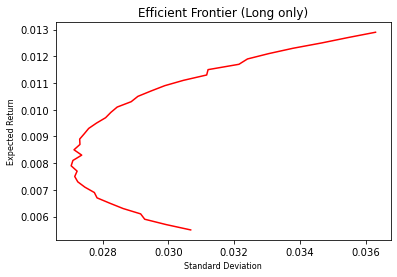

In [6]:
# plot the efficient frontier
# If weightings are bounded to be long-only [0,1], EF will not be smooth
plot1=plt.figure(1)
plt.plot(volRange,muRange,color="red")
plt.xlabel("Standard Deviation",fontsize=8)
plt.ylabel("Expected Return",fontsize=8)
plt.title("Efficient Frontier (Long only)",fontsize=12)

# save fig
plt.savefig('pic/Efficient_Frontier(NoRiskFree).png')

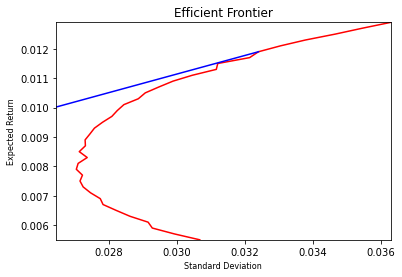

In [7]:
rf=0.02/12

# Find the mean return, volatility and weighting of the tangent line
def risk_free_EF(wgt, rf, muRange, volRange, lb=0, ub=1, step=100):
    rf_weighting = np.arange(lb,ub, 1/step)
    df = pd.DataFrame({'mean': muRange, 'sd': volRange})
    df['sharpe'] = (df['mean'] - rf) / df['sd']
    optimal = df.loc[df['sharpe'].argmax()]
    optimal_mu = optimal['mean']
    optimal_sd= optimal['sd']
    optimal_w = wgt[optimal_mu]
    
    new_wgt = dict()
    new_muRange = list()
    new_volRange = list()
    
    for alpha in rf_weighting:
        mu_i = alpha * rf + (1-alpha) * optimal_mu
        new_muRange.append(mu_i)
        new_volRange.append((1-alpha)*optimal_sd)
        new_wgt[mu_i] = np.multiply(optimal_w, 1-alpha)
    return rf_weighting, new_wgt, new_muRange, new_volRange

# Plot the EF with tangent line
def plot_EF_with_rf(rf, wgt, muRange, volRange):
    rf_weighting, new_wgt, new_muRange, new_volRange = risk_free_EF(wgt, rf, muRange, volRange)
    plot1=plt.figure(1)
    plt.plot(volRange,muRange,color="red")
    plt.plot(new_volRange,
             new_muRange,
             color='blue')
    plt.xlim([min(volRange)-(muRange[1]-muRange[0])*3, max(volRange)])
    plt.ylim([min(muRange), max(muRange)])
    plt.xlabel("Standard Deviation",fontsize=8)
    plt.ylabel("Expected Return",fontsize=8)
    plt.title("Efficient Frontier",fontsize=12)
    
plot_EF_with_rf(rf, wgt, muRange, volRange, )